In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import torch
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

c:\Users\yifen\anaconda3\envs\AIHacks\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
toy_alloy_data = pd.read_csv("../toy_alloy_data.csv")

X_col = [f'element {i}' for i in range(1,13)]
Y_col = [f'property {i}' for i in range(1,7)]

X = toy_alloy_data[X_col].values
Y = toy_alloy_data[Y_col].values

# scale Y
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# move tensors to GPU (or CPU)
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device)
X_test = torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device)

In [3]:
model = nn.Sequential(
    nn.Linear(6,9),
    nn.Softmax(1),
    nn.Linear(9,12),
    nn.Softmax(1),
    nn.Linear(12,12),
    nn.Softmax(1)
)
model.to(device)
model.double()

Sequential(
  (0): Linear(in_features=6, out_features=9, bias=True)
  (1): Softmax(dim=1)
  (2): Linear(in_features=9, out_features=12, bias=True)
  (3): Softmax(dim=1)
  (4): Linear(in_features=12, out_features=12, bias=True)
  (5): Softmax(dim=1)
)

In [4]:
# a simple training procedure with MSE loss and Adam optimiser
# directly copied from example notebook
def train(m, x, y,  max_iter):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters())
    loss_hist = []
    R2_hist = []
    y_bar = torch.mean(y, 0)

    for t in range(1, max_iter + 1):
        y_pred = m(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 0:
            loss_hist.append(loss.detach().cpu())
            R2 = 1 - torch.sum((y - y_pred)**2, 0) / torch.sum((y - y_bar)**2, 0)
            R2 = torch.mean(R2)
            R2_hist.append(R2.detach().cpu())
            print(f'epoch: {t}, loss: {float(loss.item()):.4f}, R^2: {float(R2):.4f}')
            if len(loss_hist) > 2 and torch.abs((loss_hist[-1]-loss_hist[-2])/loss_hist[-1]) < 1e-4:
                break
    return m, loss_hist, R2_hist

In [5]:
m, loss_hist, R2_hist= train(model, Y_train, X_train, max_iter=30000)

epoch: 100, loss: 0.0552, R^2: -2805.6669
epoch: 200, loss: 0.0512, R^2: -2006.6048
epoch: 300, loss: 0.0474, R^2: -1405.6661
epoch: 400, loss: 0.0430, R^2: -1016.1708
epoch: 500, loss: 0.0372, R^2: -729.8400
epoch: 600, loss: 0.0315, R^2: -496.9675
epoch: 700, loss: 0.0272, R^2: -326.7221
epoch: 800, loss: 0.0245, R^2: -219.0212
epoch: 900, loss: 0.0229, R^2: -154.8643
epoch: 1000, loss: 0.0219, R^2: -117.0063
epoch: 1100, loss: 0.0207, R^2: -95.8576
epoch: 1200, loss: 0.0188, R^2: -83.3853
epoch: 1300, loss: 0.0168, R^2: -72.2372
epoch: 1400, loss: 0.0146, R^2: -62.6728
epoch: 1500, loss: 0.0131, R^2: -52.4042
epoch: 1600, loss: 0.0123, R^2: -45.1423
epoch: 1700, loss: 0.0117, R^2: -40.6968
epoch: 1800, loss: 0.0112, R^2: -37.8144
epoch: 1900, loss: 0.0107, R^2: -35.9360
epoch: 2000, loss: 0.0102, R^2: -34.0483
epoch: 2100, loss: 0.0099, R^2: -31.3946
epoch: 2200, loss: 0.0096, R^2: -28.7599
epoch: 2300, loss: 0.0093, R^2: -26.1603
epoch: 2400, loss: 0.0091, R^2: -23.5806
epoch: 2500

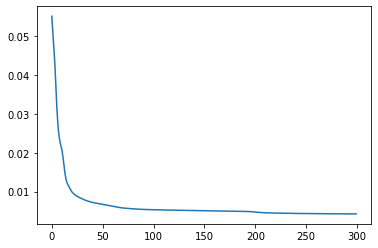

In [6]:
plt.plot(loss_hist)

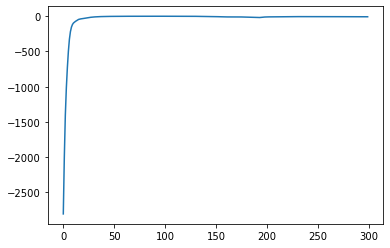

In [7]:
plt.plot(R2_hist)

In [8]:
with torch.no_grad():
    print(mean_absolute_error(model(Y_test).cpu().numpy(), X_test.cpu().numpy()))

0.015304141738419723


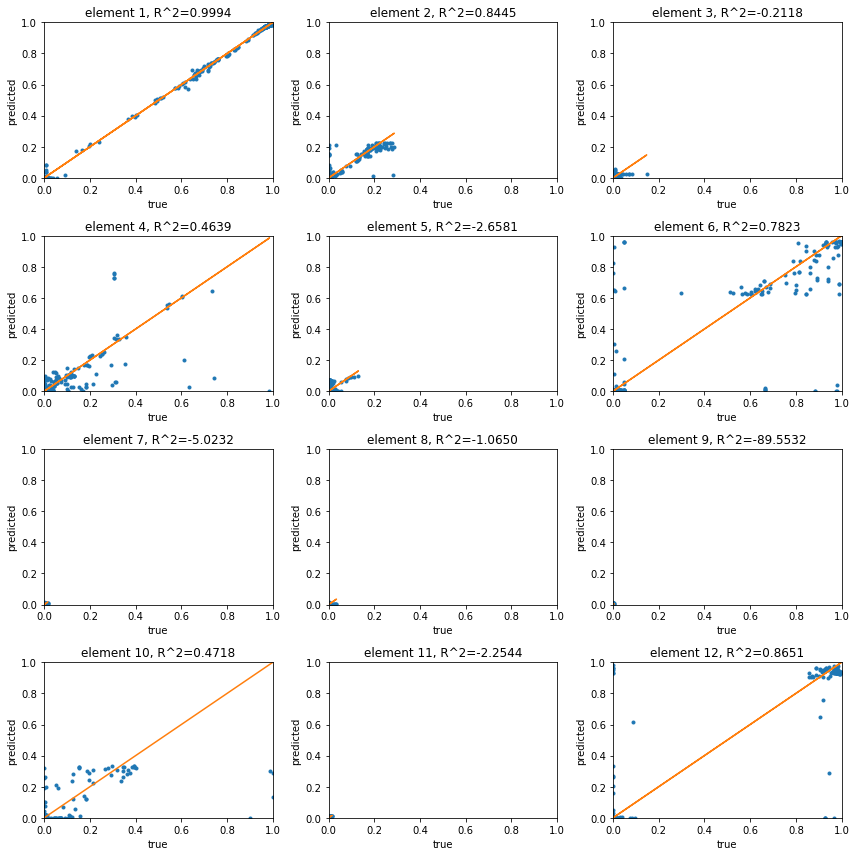

In [9]:
with torch.no_grad():
    X_pred = model(Y_test).cpu().numpy()
    X_true = X_test.cpu().numpy()

fig, axs = plt.subplots(4, 3, figsize=(12,12))
for i in range(12):
    X_bar = np.mean(X_true[:,i])
    R_2 = 1 - np.sum((X_true[:,i] - X_pred[:,i])**2) / np.sum((X_true[:,i] - X_bar)**2)
    ax = axs[i // 3, i % 3]
    ax.plot(X_true[:, i], X_pred[:, i], '.')
    ax.plot(X_true[:, i], X_true[:, i], '-')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(f'{X_col[i]}, R^2={R_2:.4f}')

plt.tight_layout()
plt.show()